In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
GOOD_REVIEW_THRESHOLD = 7

In [4]:
VAL_FRACTION = 0.25

## GET DATA

In [5]:
hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
# Parsing the XML file
xmlparse = Xet.fromstring(hot)

hot_array = []
for item in xmlparse:
    dict_element = {
        "id": item.get("id"),
        "rank": item.get("rank")
    }
    for option in item:
        dict_element[option.tag] = option.get("value")
    hot_array.append(dict_element)

In [6]:
hot_array[:2]

[{'id': '328866',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/N0hCcxXw8d7vUjKfsYO6vg__thumb/img/K4DDlRzl6qlQf9L_oMLb7g9WUYo=/fit-in/200x150/filters:strip_icc()/pic6121929.png',
  'name': "My Father's Work",
  'yearpublished': '2021'},
 {'id': '316090',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/-KMXyStWyla5jh_BRO803w__thumb/img/3j7TG-J5bxigP1RaTbNnHcHnr6A=/fit-in/200x150/filters:strip_icc()/pic6074555.png',
  'name': 'Vivid Memories',
  'yearpublished': '2021'}]

In [12]:
max_comments_per_page = 1
hot_array_ids = [h['id'] for h in hot_array]
ids = ','.join(hot_array_ids)
page_size = 100
page_number = 0
comments_array = []

while max_comments_per_page > 0 and len(hot_array_ids) > 0:
    page_number += 1
    print(f"page number = {page_number}", end=" ")
    comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

    # Parsing the XML file
    xmlparse = Xet.fromstring(comments)
    comments_per_item = []
    for item in xmlparse:        
        for option in item:
            if option.tag == 'comments':
                comments_per_page = 0
                for comment in option:
                    comments_per_page += 1
                    dict_element = {
                        "id": item.get("id"),
                        "username": comment.get("username"),
                        "rating": comment.get("rating"),
                        "value": comment.get("value")
                    }
                    comments_array.append(dict_element)
                if comments_per_page==0:
                    hot_array_ids.remove(item.get("id"))
                    ids = ','.join(hot_array_ids)
                comments_per_item.append(comments_per_page)
    max_comments_per_page = max(comments_per_item)
    print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")

page number = 1 (max: 100, len = 50)
page number = 2 (max: 100, len = 50)
page number = 3 (max: 100, len = 40)
page number = 4 (max: 100, len = 36)
page number = 5 (max: 100, len = 34)
page number = 6 (max: 100, len = 31)
page number = 7 (max: 100, len = 29)
page number = 8 (max: 100, len = 26)
page number = 9 (max: 100, len = 25)
page number = 10 (max: 100, len = 25)
page number = 11 (max: 100, len = 22)
page number = 12 (max: 100, len = 22)
page number = 13 (max: 100, len = 21)
page number = 14 (max: 100, len = 20)
page number = 15 (max: 100, len = 19)
page number = 16 (max: 100, len = 18)
page number = 17 (max: 100, len = 18)
page number = 18 (max: 100, len = 15)
page number = 19 (max: 100, len = 15)
page number = 20 (max: 100, len = 14)
page number = 21 (max: 100, len = 14)
page number = 22 (max: 100, len = 14)
page number = 23 (max: 100, len = 14)
page number = 24 (max: 100, len = 13)
page number = 25 (max: 100, len = 13)
page number = 26 (max: 100, len = 13)
page number = 27 (max

In [13]:
comments_array[:2]

[{'id': '328866',
  'username': '4tsawicki',
  'rating': 'N/A',
  'value': 'Feb 2022'},
 {'id': '328866', 'username': 'alexbatbee', 'rating': 'N/A', 'value': 'KS'}]

In [14]:
comments_df = pd.DataFrame(comments_array)

In [15]:
comments_df

,id,username,rating,value
0,328866,4tsawicki,N/A,Feb 2022
1,328866,alexbatbee,N/A,KS
2,328866,Amekins,N/A,Backer # 1267 on Kickstarter 4/27/2021 Funded ...
3,328866,bigduff,N/A,Pre-ordered on Origames web store
4,328866,BlueFoxMoon,N/A,Pre-release - Kickstarter
...,...,...,...,...
92940,167791,z_zadar,9,Some games are so much fun. Others can be a li...
92941,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
92942,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
92943,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


In [16]:
comments_df.to_csv("comments_20210429.csv", index=False)

In [17]:
# comments_df = pd.read_csv("comments_20210429.csv")

## SPLIT RATED AND NON-RATED COMMENTS

In [18]:
comments_df.rating.value_counts()

N/A        21596
10         13804
9          13705
8          12718
7           7800
           ...  
8.725          1
9.655          1
6.65333        1
7.23333        1
9.383          1
Name: rating, Length: 540, dtype: int64

In [19]:
rated_comments = comments_df.query('rating != "N/A"')

In [20]:
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)

In [21]:
rated_comments.shape

(71349, 4)

In [22]:
not_rated_comments.shape

(21596, 4)

In [24]:
# use rated comments (reviews) to train the model

In [25]:
rated_comments = rated_comments.sample(frac=1)

In [26]:
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [48]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Gives you that "one more turn!" Feel'

In [49]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'1-2 (missing 2 cards)'

## COMPOSE MODEL

In [50]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.21685015, -0.01882403, -0.06281585,  0.16949561,  0.149251  ,
        -0.12082923,  0.09053739,  0.1461488 , -0.0047862 ,  0.32872632,
         0.14902873,  0.08505921, -0.09651901,  0.01065084, -0.05212255,
         0.18700205,  0.13412444,  0.11139747, -0.00447407, -0.26588503,
        -0.03062629, -0.00104931,  0.07062511, -0.163753  , -0.31193978,
        -0.00457728, -0.36708856,  0.1620351 ,  0.13294795,  0.1170232 ,
         0.27334368,  0.05501654, -0.01759248, -0.00131858,  0.07802638,
         0.03816753,  0.1094534 , -0.07820012, -0.02809717, -0.06052911,
         0.09816911, -0.0616263 , -0.11713698, -0.1983592 , -0.03707545,
         0.12252541, -0.17544031, -0.06519897,  0.00894937,  0.19644098],
       [ 0.33198613, -0.06831744, -0.14316526,  0.01457155, -0.07885838,
        -0.17005381, -0.01117036, -0.09017784,  0.14641339,  0.01977067,
         0.23682691,  0.03196093, -0.16557589,  0.20388986,  0.34393826,
 

In [51]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

In [53]:
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

17837

## TRAINING MODEL 

In [54]:
x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

In [55]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 53512 samples, validate on 17837 samples
Epoch 1/40
53512/53512 [==============================] - 35s 656us/sample - loss: 0.5188 - accuracy: 0.8148 - val_loss: 0.4121 - val_accuracy: 0.8415
Epoch 2/40
53512/53512 [==============================] - 34s 645us/sample - loss: 0.3514 - accuracy: 0.8583 - val_loss: 0.3413 - val_accuracy: 0.8628
Epoch 3/40
53512/53512 [==============================] - 36s 664us/sample - loss: 0.2899 - accuracy: 0.8838 - val_loss: 0.3294 - val_accuracy: 0.8656
Epoch 4/40
53512/53512 [==============================] - 34s 630us/sample - loss: 0.2532 - accuracy: 0.8985 - val_loss: 0.3336 - val_accuracy: 0.8668
Epoch 5/40
53512/53512 [==============================] - 33s 626us/sample - loss: 0.2259 - accuracy: 0.9100 - val_loss: 0.3444 - val_accuracy: 0.8624
Epoch 6/40
53512/53512 [==============================] - 34s 634us/sample - loss: 0.2040 - accuracy: 0.9202 - val_loss: 0.3611 - val_accuracy: 0.8598
Epoch 7/40
53512/53512 [====================

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [58]:
epochs = range(1, len(acc) + 1) 

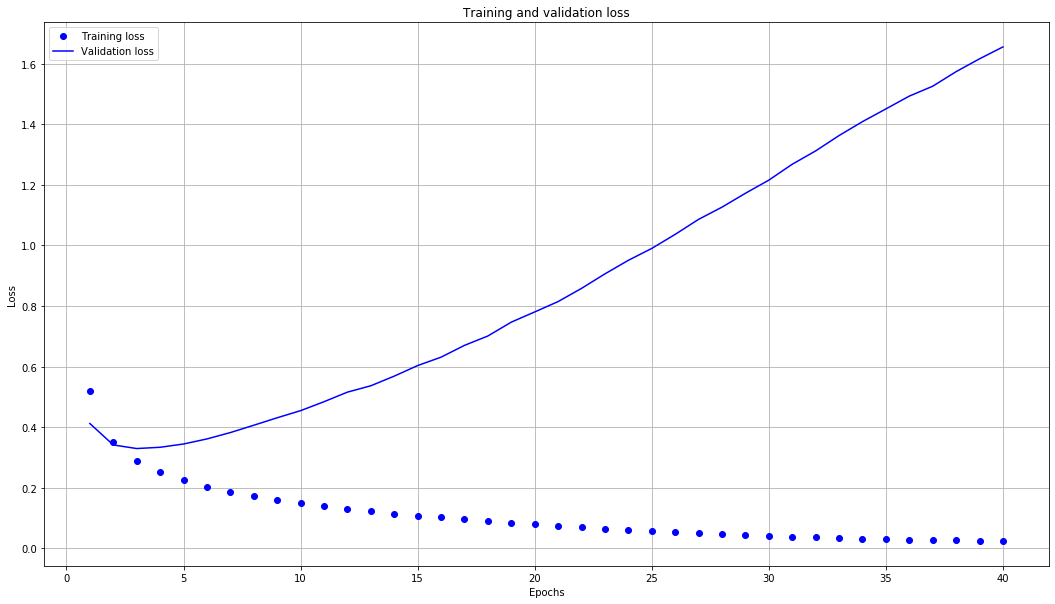

In [59]:
# "bo" is for "blue dot"
plt.figure(figsize=(18, 10))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

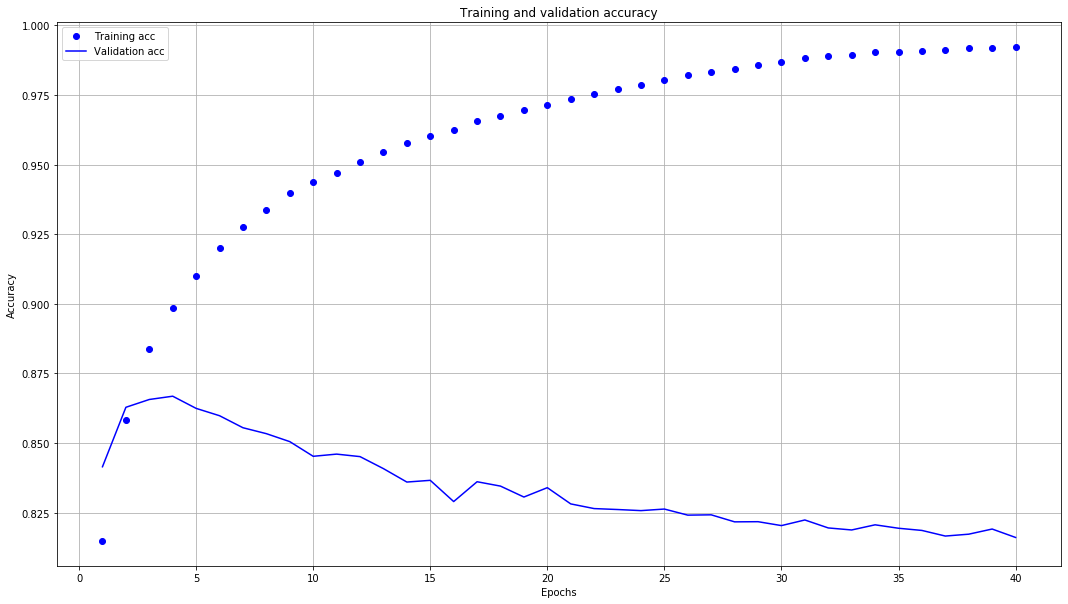

In [60]:
plt.figure(figsize=(18, 10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [61]:
def print_my_examples(inputs, results, limit=None):
    result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [62]:
inputs = x_train[-10:]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results)

input:
"Only played solo, but it's catchy..."
score: 1.000000

input:
"This is our go-to game to spend an afternoon playing. It does involve a lot of strategy and thinking through your choices, can take a long time, and does take a little bit to teach (it's best to have a few experienced players and just have an example round, although my partner and I did figure it out on our own after a few mis-plays) so it's not perfect for every game situation. But we love it! Immense replayability and you'll get chances to try all kinds of strategies."
score: 1.000000

input:
"First impressions of this game. Lots of fun. Excited to play next time.   First game took about 2 hours or so. Still looking to play this again!  Edit: Enjoy this game a great deal. We've played it 5 times now and I'm still excited for more. Very thematic game. The cards you play feel like great achievements in the goal to terraform mars. "
score: 1.000000

input:
"Genius push-your-luck gameplay that is easy to learn and has

In [63]:
y_train[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

In [64]:
## APPLY MODEL ON NON-RATED COMMENTS

In [67]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Great game, but I am not sure if its too simple. Time will tell. "
score: 0.998709

input:
"High Complexity Economic Route-building game"
score: 0.999976

input:
"2021"
score: 0.792887

input:
"Scenario 1 begins tonight! (17 August 2018)"
score: 0.999994

input:
"I should like this. But I don't. I like crunchiness but I don't like the decision making space of this game. When it's time to plan moves with a teammate it just gets confusing and AP sets in - and we're not even AP prone players! It's still in the collection for now but I don't know how long this will be with us. "
score: 0.000000

input:
"*"
score: 0.999280

input:
"+ Folded Space insert"
score: 1.000000

input:
"."
score: 0.999655

input:
"Backed on Kickstarter."
score: 1.000000

input:
"헬라스&엘리시움, 서곡 확장"
score: 0.000000

input:
"60-90 Mins, 3-4 (4) Players"
score: 0.849774

input:
"Includes:  Promo Pack 1 - KS Promo Spirits Heart of the Wildfire and Serpent Slumbering Beneath the Island"
score: 0.999459

input:
"+ J

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [68]:
rated_comments.head()

,id,username,rating,value
79084,169786,mr0santan,8,"Gives you that ""one more turn!"" Feel"
62184,148228,harrycalder,7.1,"Ding and dent copy but mostly unpunched, defin..."
40932,244521,joewyka,8,Players pull ingredients from their personal b...
79479,148228,nkcbones,9,Quick and competitive.
56152,244521,ShawSmith2007,8,So glad I got this. Another family fave that a...


In [69]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,111105,6.881935,403
1,148228,7.382325,7281
2,162886,8.351370,3465
3,163068,7.765526,938
4,163968,7.181820,1167


In [70]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [71]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,111105,7.803804,184
1,148228,8.334621,1476
2,162886,8.655088,1022
3,163068,8.696288,431
4,163968,8.304186,430


In [72]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)

In [73]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished
0,111105,6.881935,403,7.803804,184,40,https://cf.geekdo-images.com/KSrotdESv2kphKZGb...,Agents of SMERSH,2012
1,148228,7.382325,7281,8.334621,1476,31,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014
2,162886,8.351370,3465,8.655088,1022,14,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017
3,163068,7.765526,938,8.696288,431,26,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015
4,163968,7.181820,1167,8.304186,430,45,https://cf.geekdo-images.com/hNyO7u1pR3oSxKTEL...,Elysium,2015


In [74]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [75]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,fixed_rating
0,111105,6.881935,403,7.803804,184,40,https://cf.geekdo-images.com/KSrotdESv2kphKZGb...,Agents of SMERSH,2012,7.170903
1,148228,7.382325,7281,8.334621,1476,31,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014,7.542835
2,162886,8.351370,3465,8.655088,1022,14,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,8.420548
3,163068,7.765526,938,8.696288,431,26,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015,8.058556
4,163968,7.181820,1167,8.304186,430,45,https://cf.geekdo-images.com/hNyO7u1pR3oSxKTEL...,Elysium,2015,7.484023


In [76]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [77]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<center><img src="'+ path + '" style=max-height:124px;"/></center>'

In [78]:
# TOP 5 RANK
HTML(grouped.sort_values('rank').head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
44,,My Father's Work,5.375000,8.584000,8.141379,1,2021
37,,Vivid Memories,7.500000,6.760000,6.971429,2,2021
30,,Oath: Chronicles of Empire and Exile,8.040377,8.821176,8.591911,3,2021
36,,Lost Ruins of Arnak,7.952460,8.478000,8.107578,4,2020
38,,Dune: Imperium,8.119984,8.423394,8.199388,6,2020


In [79]:
# TOP 5 REVIEW RANK
HTML(grouped.sort_values('rating_mean_review', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
40,,Stationfall,9.428571,8.500000,9.000000,25,2021
32,,Kemet: Blood and Sand,8.921053,8.553591,8.588500,35,2021
20,,Eclipse: Second Dawn for the Galaxy,8.734295,8.988362,8.824285,39,2020
16,,Brass: Birmingham,8.688614,8.659131,8.680177,22,2018
29,,Gloomhaven: Jaws of the Lion,8.623618,8.449773,8.575781,19,2020


In [80]:
# TOP 5 FIXED RANK
HTML(grouped.sort_values('fixed_rating', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
40,,Stationfall,9.428571,8.500000,9.000000,25,2021
28,,Zombicide (2nd Edition),7.617021,9.432773,8.918675,41,2021
20,,Eclipse: Second Dawn for the Galaxy,8.734295,8.988362,8.824285,39,2020
46,,Brew,6.600000,9.922222,8.735714,13,2021
16,,Brass: Birmingham,8.688614,8.659131,8.680177,22,2018


In [82]:
model.save('saved_model\my_model')

INFO:tensorflow:Assets written to: saved_model\my_model\assets


INFO:tensorflow:Assets written to: saved_model\my_model\assets


In [86]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [87]:
# some examples on "long" comments vs short comments

In [92]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [98]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Hard to rate but I'm enjoying it so far. I'm feeling like I don't see the strategic depth to this game. I don't know if I just need to play more or if there isn't much depth."
score: 0.991876

input:
"Was a beast and took some time to get to the table, definitely got some rules wrong, but thoroughly enjoy the gameplay, the character developments and all the story elements. Can’t say enough about how great it is."
score: 1.000000

input:
"Оба Брасса мне кажутся очень сухими и я не понимаю в чем тут прикол. Тянусь за ними только из-за хайпа, который непонятно чем вызван. За такую цену, я думаю - необоснованная покупка."
score: 0.011818

input:
"STATUS: Keep Designer: Matthew Dunstan, Brett J. Gilbert  Publisher: Asmodee Player Count: 3 Best Notes:"
score: 1.000000

input:
"#4305/11320 échange avec Bastet +30$ 02/08/16 + Invaders from Afar expansion + promo 8-9-10 + The Wind Gambit expansion + Large Action Tokens + The Rise of Fenris expansion"
score: 1.000000

input:
"Of course I